In [1]:
import numpy as np
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from utils import *
from model import *

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from PIL import Image
from pycocotools.coco import COCO
import cv2
from torch.nn import L1Loss

In [2]:
# Check if CUDA is available
if torch.cuda.is_available():
    # Use CUDA devices
    device = torch.device("cuda")
    print("CUDA is available. Using GPU:", torch.cuda.get_device_name(0))  # Print GPU device name
else:
    # Use CPU
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU: NVIDIA GeForce RTX 3070 Laptop GPU


In [3]:
#Important Constants 
img_width = 640
img_height = 480 #656
orig_w = 3936
orig_h = 2624

In [4]:
class AnnotationParser(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))
            
    def __getitem__(self, index):
        # Own coco file
        coco = self.coco

        # Image ID
        img_id = self.ids[index]
        
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=[img_id])
        
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)

        # path for input image
        path = coco.loadImgs([img_id])[0]['file_name']
        # print("path = ", path)

        # open the input image
        img = Image.open(os.path.join(self.root, path))
        
        num_objs = len(coco_annotation)
        
        boxes = []
        labels = []
        # idx = []
        groundtruth_boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]

            boxes = torch.Tensor([xmin, ymin, xmax, ymax])
            # rescale bboxes
            boxes[[0, 2]] = boxes[[0, 2]] * img_width/orig_w
            boxes[[1, 3]] = boxes[[1, 3]] * img_height/orig_h
            # print("Boxes = ", boxes)
            groundtruth_boxes.append(boxes.tolist())
            labels.append(coco_annotation[i]['category_id'] - 1)
            # idx.append(coco_annotation[i]['id'])
        # boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # print("groundtruth_boxes = ", groundtruth_boxes)
        # print("labels = ", labels)
        # print("path = ", path)
        # print("idx = ", idx)
        if self.transforms is not None:
            img = self.transforms(img)

        # return img, my_annotation
        return path, groundtruth_boxes, labels
    
    def __len__(self):
        return len(self.ids)
        

In [5]:
# SRGB 22 images
# image_dir = "C:/Users/ravin/Desktop/OBJ_DET/Coco_style_Fasterrcnn/data/train/"
# annotation_path = "C:/Users/ravin/Desktop/OBJ_DET/Coco_style_Fasterrcnn/data/train/coco_subset_srgb.json"


# Linear RGB
# image_dir = "C:/Users/ravin/Desktop/OBJ_DET/Coco_style_Fasterrcnn/data_linear_rgb/train/" 
# annotation_path = "C:/Users/ravin/Desktop/OBJ_DET/Coco_style_Fasterrcnn/data_linear_rgb/train/coco_subset_Lrgb.json"

#sRGB Images - 552 images
# image_dir = "C:/Users/ravin/Desktop/OBJ_DET/GenISP_resized_srgb/"
# annotation_path = "C:/Users/ravin/Desktop/OBJ_DET/GenISP_resized_srgb/coco_srgb_subset.json"

#552 images linear RGB
image_dir = "C:/Users/ravin/Desktop/OBJ_DET/GenISP_subset_linearrgb/"
annotation_path = "C:/Users/ravin/Desktop/OBJ_DET/GenISP_subset_linearrgb/coco_srgb_subset.json"

#256 images linear RGB
# image_dir = "C:/Users/ravin/Desktop/OBJ_DET/GenISP_subset_linearrgb_256/"
# annotation_path = "C:/Users/ravin/Desktop/OBJ_DET/GenISP_subset_linearrgb_256/coco_srgb_subset.json"

In [7]:
class ObjectDetectionDataset(Dataset):
    '''
    A Pytorch Dataset class to load the images and their corresponding annotations.
    
    Returns
    ------------
    images: torch.Tensor of size (B, C, H, W)
    gt bboxes: torch.Tensor of size (B, max_objects, 4)
    gt classes: torch.Tensor of size (B, max_objects)
    '''
    def __init__(self, annotation_path, img_dir, img_size, name2idx):
        self.annotation_path = annotation_path
        self.img_dir = img_dir
        self.img_size = img_size
        self.name2idx = name2idx
        # print("self.img_size = ", self.img_size)
        
        self.img_data_all, self.gt_bboxes_all, self.gt_classes_all, self.img_idx = self.get_data()
        
    def __len__(self):
        return self.img_data_all.size(dim=0)
    
    def __getitem__(self, idx):
        return self.img_data_all[idx], self.gt_bboxes_all[idx], self.gt_classes_all[idx], self.img_idx[idx]
        
    def get_data(self):
        img_data_all = []
        gt_idxs_all = []
        img_idx = []
        # Create an instance of AnnotationParser to get the data
        annotation_parser = AnnotationParser(root=self.img_dir, annotation=self.annotation_path)
        # print(type(annotation_parser))
        
        separated_img_paths = []
        separated_gt_boxes = []
        separated_gt_classes = []

        for annotation in annotation_parser:
            img_paths, gt_boxes_all, gt_classes_all = annotation
            # print(" gt_boxes_all = ", gt_boxes_all)
            if gt_boxes_all:
                separated_img_paths.append(image_dir + img_paths)
                separated_gt_boxes.append(torch.Tensor(gt_boxes_all))
                separated_gt_classes.append(gt_classes_all)

        # Print or use the separated data as needed
        # print("Separated Image Paths:", separated_img_paths)
        # print("Separated Ground Truth Boxes:", separated_gt_boxes)
        # print("Separated Ground Truth Classes:", separated_gt_classes)

        for i, img_path in enumerate(separated_img_paths):
                       
            # skip if the image path is not valid
            if (not img_path) or (not os.path.exists(img_path)):
                continue
             
            # read and resize image sRGB
            # img = cv2.imread(img_path)

            # read linear RGB image
            img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, self.img_size, interpolation=cv2.INTER_CUBIC)
            img = img.astype(np.float32)
            #Standard RGB
            # img /= 255

            #Linear RGB
            # img /= 65535.0
            
            #LOG RGB
            img[img != 0] = np.log(img[img != 0])

            img_tensor = torch.from_numpy(img).permute(2, 0, 1) # convert image to torch tensor and reshape it so channels come first
        
            # encode class names as integers
            gt_classes = separated_gt_classes[i]
            # print("gt_classes = ", gt_classes)
            
            gt_idx = torch.Tensor(gt_classes).float()
            # print("gt_idx = ", gt_idx)
            
            img_data_all.append(img_tensor)
            gt_idxs_all.append(gt_idx)
            img_idx.append(i)
        # pad bounding boxes and classes so they are of the same size
        gt_bboxes_pad = pad_sequence(separated_gt_boxes, batch_first=True, padding_value=-1)
        gt_classes_pad = pad_sequence(gt_idxs_all, batch_first=True, padding_value=-1)
        
        # stack all images
        img_data_stacked = torch.stack(img_data_all, dim=0)
        print(gt_bboxes_pad.shape)
        print(gt_classes_pad.shape)
        print(len(img_idx))
        # print(gt_bboxes_pad)
        return img_data_stacked.to(dtype=torch.float32), gt_bboxes_pad, gt_classes_pad, img_idx

In [8]:
img_width = 640
img_height = 480
name2idx = {'pad': -1, 'person': 0, 'bicycle': 1, 'car':2}
idx2name = {v:k for k, v in name2idx.items()}
print(idx2name)
print(name2idx)

{-1: 'pad', 0: 'person', 1: 'bicycle', 2: 'car'}
{'pad': -1, 'person': 0, 'bicycle': 1, 'car': 2}


In [10]:
image_dir, annotation_path
od_dataset = ObjectDetectionDataset(annotation_path, image_dir, (img_width, img_height), name2idx)
train_size = int(0.70 * len(od_dataset))
val_size = int(0.15 * len(od_dataset))
test_size = len(od_dataset) - (train_size + val_size)
print(train_size, val_size, test_size)
train_set, val_set, test_set= torch.utils.data.random_split(od_dataset, [train_size, val_size, test_size])
train_dataloader = DataLoader(train_set, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=2, shuffle=False)
val_dataloader = DataLoader(val_set, batch_size=2, shuffle=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
torch.Size([422, 40, 4])
torch.Size([422, 40])
422
295 63 64


In [10]:
# od_dataloader = DataLoader(od_dataset, batch_size=4)

In [11]:
true_boxes = []
 
for img_batch, gt_bboxes_batch, gt_classes_batch, idx in train_dataloader:

  # print(gt_bboxes_batch.shape)
  batch_boxes = create_list_of_lists(img_batch, gt_bboxes_batch, gt_classes_batch, idx)
  true_boxes.extend(batch_boxes)

In [12]:
for img_batch, gt_bboxes_batch, gt_classes_batch, idx in train_dataloader:
    print("img_batch = ", img_batch.shape)
    print("idx = ", idx.shape)
    img_data_all = img_batch
    gt_bboxes_all = gt_bboxes_batch
    gt_classes_all = gt_classes_batch
    break  
img_data_all = img_data_all[:2]
gt_bboxes_all = gt_bboxes_all[:2]
gt_classes_all = gt_classes_all[:2]
idx_all = idx[:2]


img_batch =  torch.Size([4, 3, 480, 640])
idx =  torch.Size([4])


In [13]:
# get class names
gt_class_1 = gt_classes_all[0].long()
gt_class_1 = [idx2name[idx.item()] for idx in gt_class_1]

gt_class_2 = gt_classes_all[1].long()
gt_class_2 = [idx2name[idx.item()] for idx in gt_class_2]

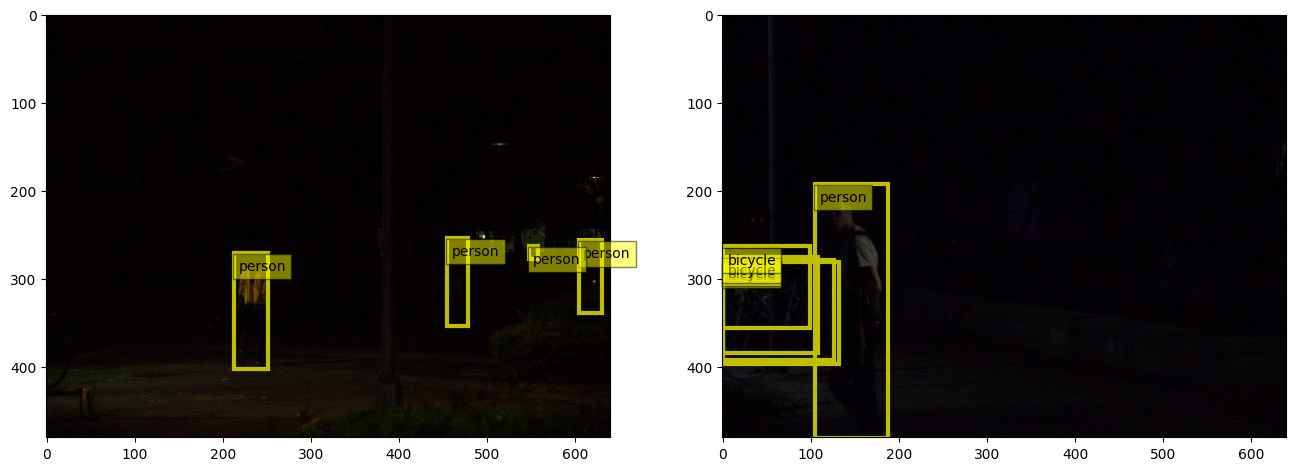

In [12]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)
fig, _ = display_bbox(gt_bboxes_all[0], fig, axes[0], classes=gt_class_1)
fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1], classes=gt_class_2)

In [14]:
model = torchvision.models.resnet50(pretrained=True)

c:\Users\ravin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ravin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
req_layers = list(model.children())[:8]
backbone = nn.Sequential(*req_layers)
# unfreeze all the parameters
for param in backbone.named_parameters():
    param[1].requires_grad = True

In [16]:
# run the image through the backbone
out = backbone(img_data_all)
out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)
out_c, out_h, out_w

(2048, 15, 20)

In [17]:
width_scale_factor = img_width // out_w
height_scale_factor = img_height // out_h
height_scale_factor, width_scale_factor

(32, 32)

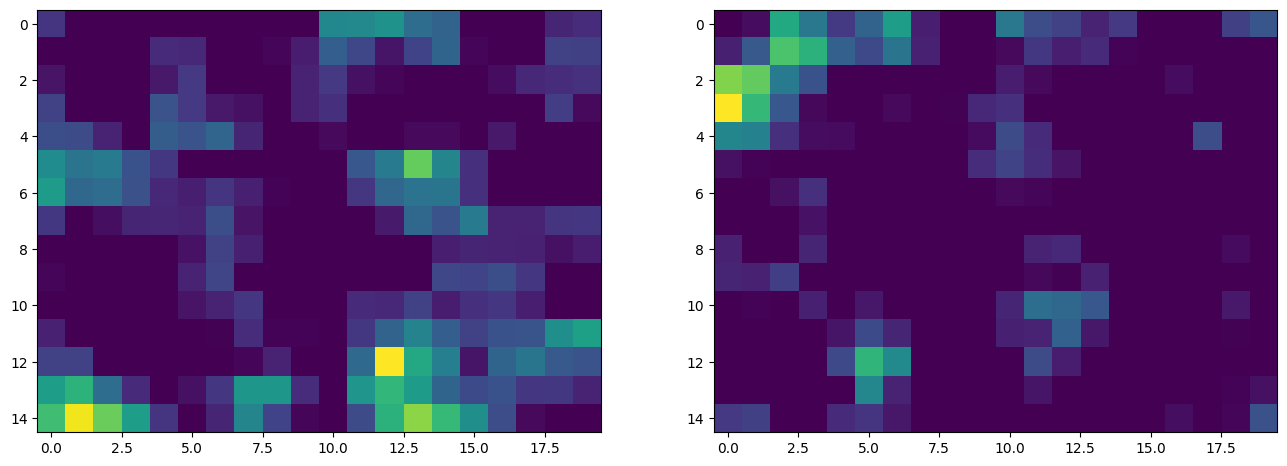

In [17]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

filters_data =[filters[0].detach().numpy() for filters in out[:2]]

fig, axes = display_img(filters_data, fig, axes)


In [18]:
anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(out_h, out_w))

In [19]:
anc_pts_x, anc_pts_y

(tensor([ 0.5000,  1.5000,  2.5000,  3.5000,  4.5000,  5.5000,  6.5000,  7.5000,
          8.5000,  9.5000, 10.5000, 11.5000, 12.5000, 13.5000, 14.5000, 15.5000,
         16.5000, 17.5000, 18.5000, 19.5000]),
 tensor([ 0.5000,  1.5000,  2.5000,  3.5000,  4.5000,  5.5000,  6.5000,  7.5000,
          8.5000,  9.5000, 10.5000, 11.5000, 12.5000, 13.5000, 14.5000]))

In [20]:
# project anchor centers onto the original image
anc_pts_x_proj = anc_pts_x.clone() * width_scale_factor 
anc_pts_y_proj = anc_pts_y.clone() * height_scale_factor

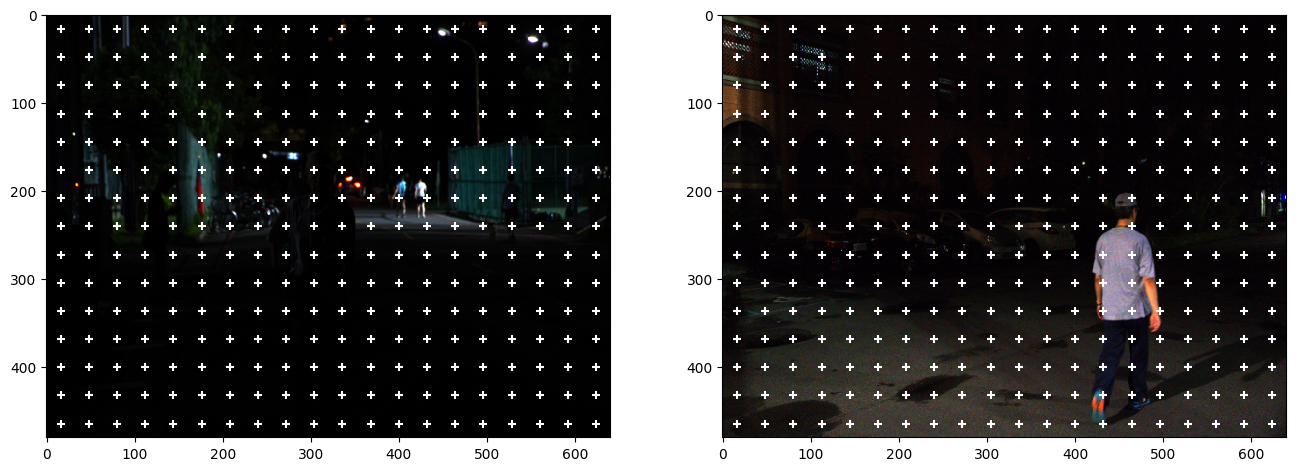

In [23]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
 
fig, axes = display_img(img_data_all, fig, axes)
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])

In [21]:
anc_scales = [2, 4, 6]
anc_ratios = [0.5, 1, 1.5]
n_anc_boxes = len(anc_scales) * len(anc_ratios) # number of anchor boxes for each anchor point

anc_base = gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, (out_h, out_w))

In [22]:
# since all the images are scaled to the same size
# we can repeat the anchor base for all the images
anc_boxes_all = anc_base.repeat(img_data_all.size(dim=0), 1, 1, 1, 1)

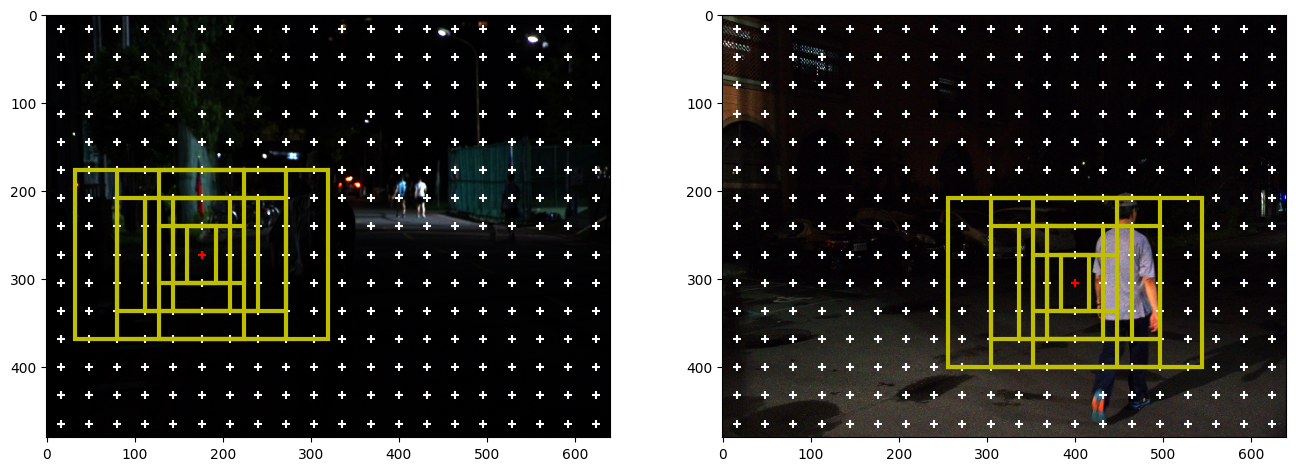

In [26]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# project anchor boxes to the image
anc_boxes_proj = project_bboxes(anc_boxes_all, width_scale_factor, height_scale_factor, mode='a2p')

# plot anchor boxes around selected anchor points
sp_1 = [5, 8]
sp_2 = [12, 9]
bboxes_1 = anc_boxes_proj[0][sp_1[0], sp_1[1]]
bboxes_2 = anc_boxes_proj[1][sp_2[0], sp_2[1]]

fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0], (anc_pts_x_proj[sp_1[0]], anc_pts_y_proj[sp_1[1]]))
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1], (anc_pts_x_proj[sp_2[0]], anc_pts_y_proj[sp_2[1]]))
fig, _ = display_bbox(bboxes_1, fig, axes[0])
fig, _ = display_bbox(bboxes_2, fig, axes[1])

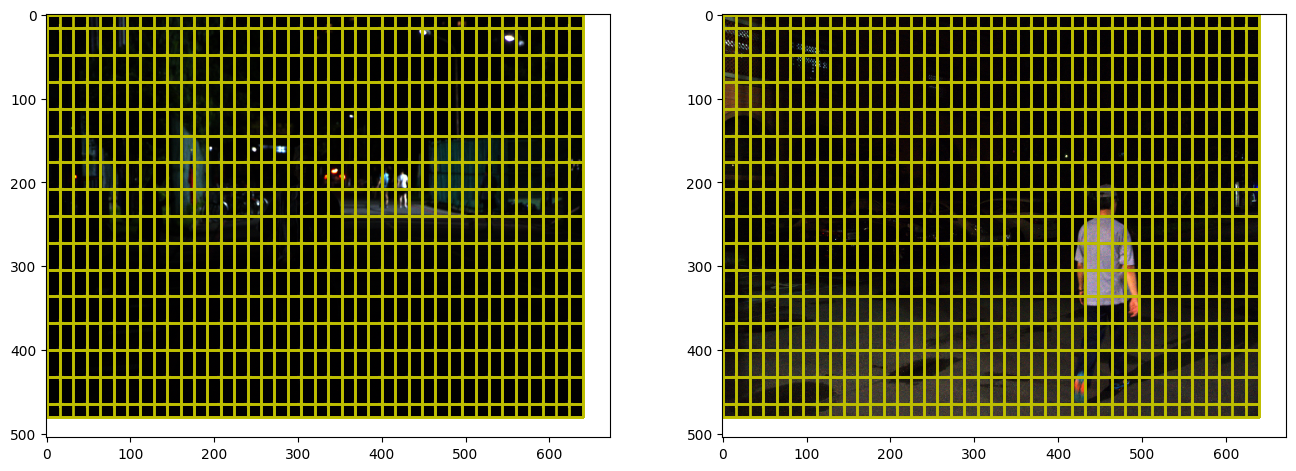

In [27]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# plot feature grid
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])

# plot all anchor boxes
for x in range(anc_pts_x_proj.size(dim=0)):
    for y in range(anc_pts_y_proj.size(dim=0)):
        bboxes = anc_boxes_proj[0][x, y]
        fig, _ = display_bbox(bboxes, fig, axes[0], line_width=1)
        fig, _ = display_bbox(bboxes, fig, axes[1], line_width=1)

In [23]:
pos_thresh = 0.7
neg_thresh = 0.3

# project gt bboxes onto the feature map
gt_bboxes_proj = project_bboxes(gt_bboxes_all, width_scale_factor, height_scale_factor, mode='p2a')

In [24]:
positive_anc_ind, negative_anc_ind, GT_conf_scores, \
GT_offsets, GT_class_pos, positive_anc_coords, \
negative_anc_coords, positive_anc_ind_sep = get_req_anchors(anc_boxes_all, gt_bboxes_proj, gt_classes_all, pos_thresh, neg_thresh)

In [25]:
# project anchor coords to the image space
pos_anc_proj = project_bboxes(positive_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')
neg_anc_proj = project_bboxes(negative_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')

# grab +ve and -ve anchors for each image separately

anc_idx_1 = torch.where(positive_anc_ind_sep == 0)[0]
anc_idx_2 = torch.where(positive_anc_ind_sep == 1)[0]

pos_anc_1 = pos_anc_proj[anc_idx_1]
pos_anc_2 = pos_anc_proj[anc_idx_2]

neg_anc_1 = neg_anc_proj[anc_idx_1]
neg_anc_2 = neg_anc_proj[anc_idx_2]

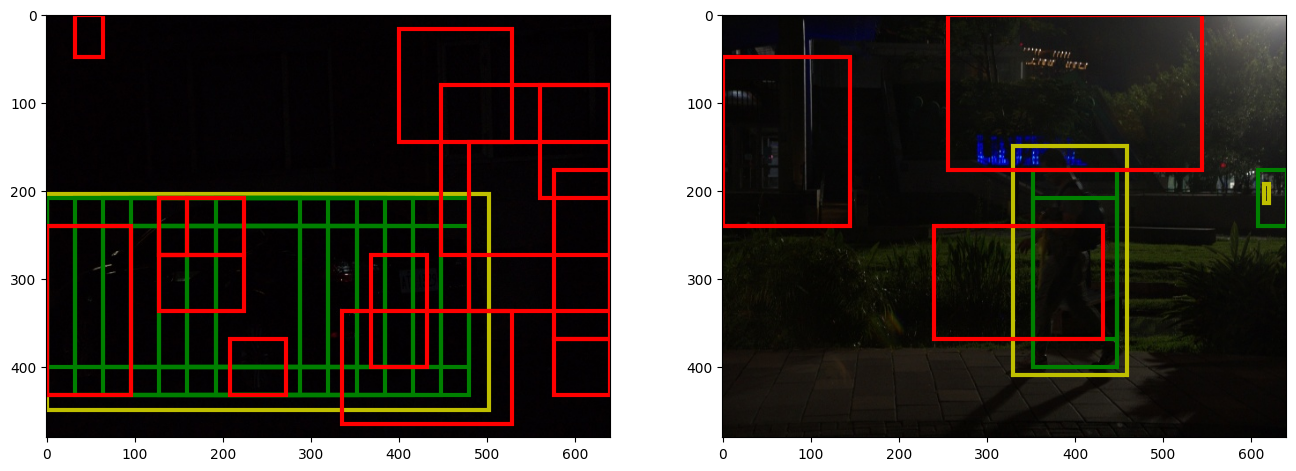

In [29]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# plot groundtruth bboxes
fig, _ = display_bbox(gt_bboxes_all[0], fig, axes[0])
fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1])

# plot positive anchor boxes
fig, _ = display_bbox(pos_anc_1, fig, axes[0], color='g')
fig, _ = display_bbox(pos_anc_2, fig, axes[1], color='g')

# plot negative anchor boxes
fig, _ = display_bbox(neg_anc_1, fig, axes[0], color='r')
fig, _ = display_bbox(neg_anc_2, fig, axes[1], color='r')

In [26]:
img_size = (img_height, img_width)
print(img_size)
out_size = (out_h, out_w)
n_classes = len(name2idx) - 1 # exclude pad idx
print(n_classes)
roi_size = (2, 2)

detector = TwoStageDetector(img_size, out_size, out_c, n_classes, roi_size)

(480, 640)
3


In [27]:
detector.eval()
# print("gt_bboxes_batch = ", gt_bboxes_batch)

# print("gt_classes_batch = ", gt_classes_batch)
total_loss = detector(img_batch, gt_bboxes_batch, gt_classes_batch)
proposals_final, conf_scores_final, classes_final = detector.inference(img_batch)

In [28]:
total_loss

# srgb --> 422 images --> 264 trainset --> total forward loss = 27.1648
# linear rgb -> tensor(21.6778, device='cuda:0', grad_fn=<AddBackward0>)
# old data
# srgb Loss = tensor(17.9549, grad_fn=<AddBackward0>) tensor(67.4792, device='cuda:0', grad_fn=<AddBackward0>)
# Linear RGB loss = tensor(17.2221, grad_fn=<AddBackward0>) tensor(65.4792, device='cuda:0', grad_fn=<AddBackward0>) tensor(67.3428, device='cuda:0', grad_fn=<AddBackward0>)

tensor(79.5939, device='cuda:0', grad_fn=<AddBackward0>)

In [38]:
def validation_loop(model, val_dataloader):
  """
  Calculate and return the validation loss for a given model and data loader.

  Args:
    model: The object detection model.
    val_dataloader: The data loader for the validation data.

  Returns:
    val_loss: The average loss over the validation data.
  """
  model.eval()  # Set the model to evaluation mode.
  total_loss = 0
  # criterion = L1Loss()
  
  with torch.no_grad():
    for img_batch, gt_bboxes_batch, gt_classes_batch, idx in val_dataloader:
      img_batch = img_batch.to(device)
      gt_bboxes_batch = gt_bboxes_batch.to(device)
      gt_classes_batch = gt_classes_batch.to(device)

      loss = model(img_batch, gt_bboxes_batch, gt_classes_batch)
      # loss = criterion(loss_out, gt_bboxes_batch)
      total_loss += loss.item()

  val_loss = total_loss / len(val_dataloader)
  return val_loss

In [40]:
def training_loop(model, learning_rate, train_dataloader, val_dataloader, n_epochs):
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    # criterion = L1Loss()

    train_loss_list = []
    val_loss_list = []
    
    for i in tqdm(range(n_epochs)):
        model.train()
        total_loss = 0
        for img_batch_train, gt_bboxes_batch, gt_classes_batch, idx in train_dataloader:
            
            # Move data to CUDA device
            img_batch_train = img_batch_train.to(device)
            gt_bboxes_batch = gt_bboxes_batch.to(device)
            gt_classes_batch = gt_classes_batch.to(device)
            
            # forward pass
            loss = model(img_batch_train, gt_bboxes_batch, gt_classes_batch)
            
            
            # backpropagation
            optimizer.zero_grad()
            # calculate the loss using L1Loss
            # loss = criterion(loss_output, gt_bboxes_batch)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        epoch_loss = total_loss / len(train_dataloader)
        train_loss_list.append(epoch_loss)
        
        # Validation phase
        model.eval()  # Set model to evaluation mode.
        val_loss = validation_loop(model, val_dataloader)
        val_loss_list.append(val_loss)
        # print("idx = ", idx)

        # print(f"Epoch {i+1}: Train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")
        
    return train_loss_list, val_loss_list

In [41]:
print(device)
detector = detector.to(device)

cuda


In [42]:
learning_rate = 1e-3
n_epochs = 1000

train_loss_list, val_loss_list = training_loop(detector, learning_rate, train_dataloader=train_dataloader, val_dataloader=val_dataloader, n_epochs=n_epochs)

100%|██████████| 1000/1000 [7:26:26<00:00, 26.79s/it] 


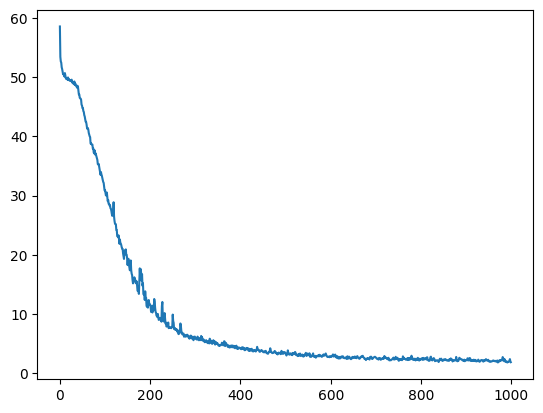

In [43]:
plt.plot(train_loss_list)

In [45]:
torch.save(detector.state_dict(), "log_model_1000Epochs_500imgs.pt")

In [46]:
img_batch = img_batch.to(device)
gt_bboxes_batch = gt_bboxes_batch.to(device)
gt_classes_batch = gt_classes_batch.to(device)

In [47]:
# mAP on train dataset
detector.eval()
pred_box = []
for img_batch, gt_bboxes_batch, gt_classes_batch, idx in train_dataloader:
    img_batch = img_batch.to(device)
    proposals_final, conf_scores_final, classes_final = detector.inference(img_batch, conf_thresh=0.99, nms_thresh=0.05)
    for proposals_pred, conf_pred, class_pred, img_idx in zip(proposals_final, conf_scores_final, classes_final, idx):
        all_proposals = []
        for i, proposal_tensor in enumerate(proposals_pred):
            # Convert tensor to list
            # print(proposal_tensor)
            proposal_tensor = scale_single_bbox(proposal_tensor, width_scale_factor, height_scale_factor, mode='a2p')
            proposal_list = proposal_tensor.tolist()
            x1, y1, x2, y2 = proposal_list
            class_label = class_pred[i].item()
            conf_score = conf_pred[i].item()
            
            all_proposals.append([int(img_idx), class_label, conf_score, x1, y1, x2, y2])

        pred_box.extend(all_proposals)
# print(pred_box)

In [56]:
mean_avg_prec, precisions, recalls = mean_average_precision(pred_box, true_boxes, iou_threshold=0.50, num_classes=3)

In [48]:
iou_thresholds = np.arange(0.5, 1.0, 0.05)
all_maps = []  # List to store mAP values for each IOU threshold

for threshold in iou_thresholds:
    mAP, _, _ = mean_average_precision(pred_box, true_boxes, threshold, num_classes=3)
    all_maps.append(mAP)
print(all_maps)
final_mAP = np.mean(all_maps)
print("mAP@0.5:0.05:0.95 = ", final_mAP)

# 550 Images
# standard RGB [tensor(0.3996), tensor(0.3875), tensor(0.3719), tensor(0.3455), tensor(0.3154), tensor(0.2782), tensor(0.2096), tensor(0.1013), tensor(0.0235), tensor(0.0006)]
# standard RGB mAP@0.5:0.05:0.95 =  0.24331062

# Linear [tensor(0.4745), tensor(0.4638), tensor(0.4473), tensor(0.4271), tensor(0.3831), tensor(0.3234), tensor(0.2334), tensor(0.1330), tensor(0.0334), tensor(0.0011)]
# Linear  mAP@0.5:0.05:0.95 =  0.29199868

# LOG RGB  [tensor(0.4799), tensor(0.4721), tensor(0.4579), tensor(0.4383), tensor(0.4032), tensor(0.3435), tensor(0.2537), tensor(0.1527), tensor(0.0404), tensor(0.0007)]
# mAP@0.5:0.05:0.95 =  0.3042501

# 200 images
# linear RGB [tensor(0.4109), tensor(0.4017), tensor(0.3808), tensor(0.3524), tensor(0.3142), tensor(0.2608), tensor(0.1831), tensor(0.0759), tensor(0.0129), tensor(0.0003)]
# linear RGB mAP@0.5:0.05:0.95 =  0.23929945

# Linear 22 images [tensor(0.7653), tensor(0.7653), tensor(0.7653), tensor(0.7239), tensor(0.7239), tensor(0.6789), tensor(0.6236), tensor(0.5305), tensor(0.4962), tensor(0.1101)]
# mAP@0.5:0.05:0.95 =  0.61831266

# srgb 22 immgs[tensor(0.7181), tensor(0.6997), tensor(0.6997), tensor(0.6682), tensor(0.6044), tensor(0.5935), tensor(0.4488), tensor(0.4046), tensor(0.3580), tensor(0.0694)]
# mAP@0.5:0.05:0.95 =  0.52645075

[tensor(0.4799), tensor(0.4721), tensor(0.4579), tensor(0.4383), tensor(0.4032), tensor(0.3435), tensor(0.2537), tensor(0.1527), tensor(0.0404), tensor(0.0007)]
mAP@0.5:0.05:0.95 =  0.3042501


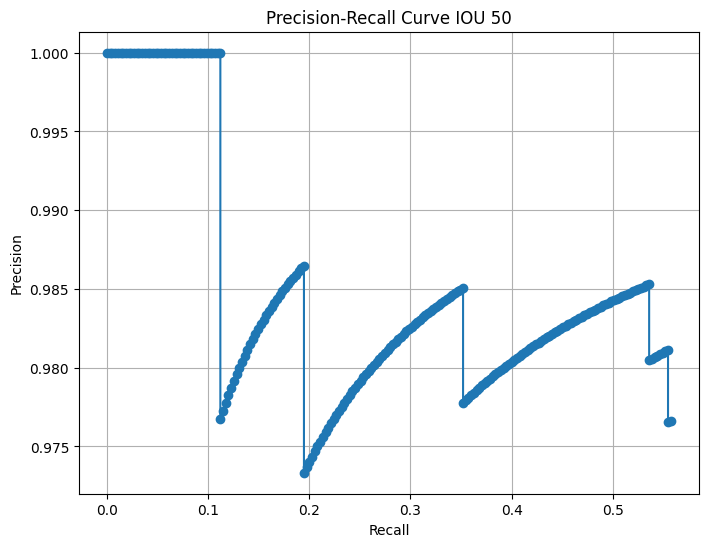

In [57]:
# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, marker='o', linestyle='-')

# Add labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve IOU 50')

# Show grid
plt.grid(True)

# Show the plot
plt.show()

In [167]:
# project proposals to the image space
prop_proj_1 = project_bboxes(proposals_final[0], width_scale_factor, height_scale_factor, mode='a2p')
prop_proj_2 = project_bboxes(proposals_final[1], width_scale_factor, height_scale_factor, mode='a2p')

# get classes
classes_pred_1 = [idx2name[cls] for cls in classes_final[0].tolist()]
classes_pred_2 = [idx2name[cls] for cls in classes_final[1].tolist()]

In [168]:
classes_pred_1

['person', 'person', 'person', 'person', 'person', 'person']

In [169]:
classes_pred_2

['person', 'person']

In [170]:
import matplotlib.pyplot as plt
import torch
import torchvision.ops as ops
import numpy as np
import matplotlib.patches as patches

def display_bbox1(bboxes, fig, ax, classes=None, in_format='xyxy', color='y', line_width=3):
    if type(bboxes) == np.ndarray:
        bboxes = torch.from_numpy(bboxes)
    
    if classes:
        assert len(bboxes) == len(classes)
    
    # Convert boxes to xywh format
    bboxes = ops.box_convert(bboxes, in_fmt=in_format, out_fmt='xywh')
    
    # print("bboxes = ", bboxes)
    c = 0
    for box in bboxes:
        # Move the box tensor to CPU if it's on GPU (CUDA)
        if isinstance(box, torch.Tensor) and box.device.type == 'cuda':
            box = box.cpu()
        
        x, y, w, h = box.numpy()
        
        # Display bounding box
        rect = patches.Rectangle((x, y), w, h, linewidth=line_width, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        
        # Display category
        if classes:
            if classes[c] == 'pad':
                continue
            ax.text(x + 5, y + 20, classes[c], bbox=dict(facecolor='yellow', alpha=0.5))
        
        c += 1
        
    return fig, ax


In [171]:
torch.set_printoptions(precision=4, sci_mode=False)

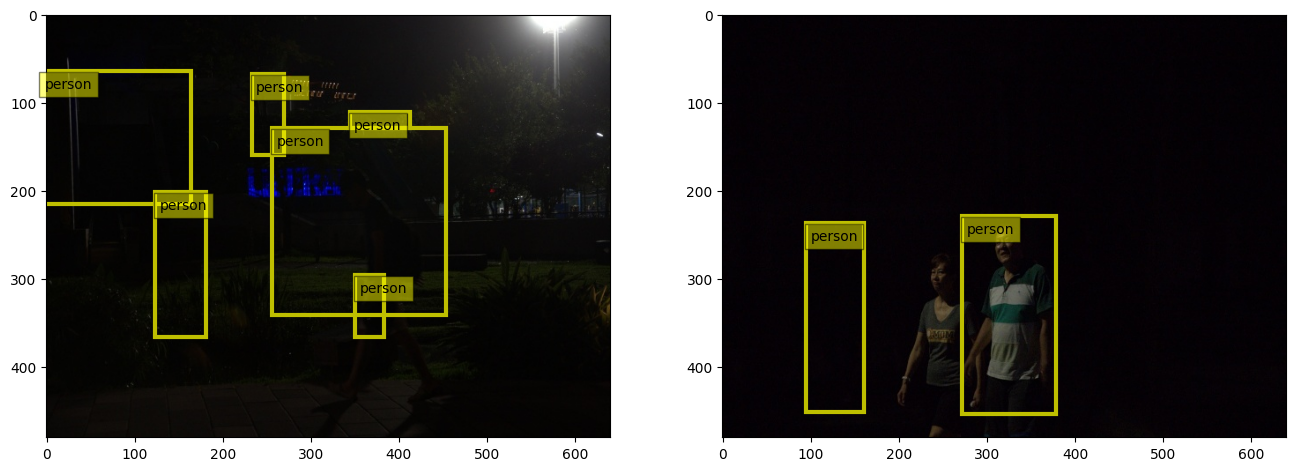

In [172]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
img_batch_cpu = img_batch.cpu()
img_batch_cpu = img_batch_cpu[:2]

fig, axes = display_img(img_batch_cpu, fig, axes)
fig, _ = display_bbox1(prop_proj_1, fig, axes[0], classes=classes_pred_1)
fig, _ = display_bbox1(prop_proj_2, fig, axes[1], classes=classes_pred_2)